# Using NLP Vectorization Techniques to Group Jeopardy Questions

#### By William J. Suh

<img src = "http://www.okayplayer.com/wp-content/uploads/2016/07/Jeopardy-690.jpg">

## Data Science Question:

Can I categorize Jeopardy questions by topics? <br>
Most Jeopardy questions have categorical 'titles' that provide contextual clues but doesn't categorize questions by subject. What is the best clustering method to categorize them?

Clustering questions by topic enables aspiring Jeopardy contestants to study more efficiently.


## Imports

In [3]:
# usual suspects
import pandas                              as pd
import numpy                               as np
import matplotlib.pyplot                   as plt
import seaborn                             as sns

# gensim
from gensim.models                         import Doc2Vec
import gensim.models.doc2vec
from gensim                                import utils
from gensim.models.doc2vec                 import TaggedDocument, LabeledSentence
import gensim
from gensim                                import corpora, models
from gensim.test.utils                     import get_tmpfile

# random
from random import shuffle

from sklearn                               import utils

# pre-processing 
from nltk.corpus                           import stopwords
from nltk.stem                             import WordNetLemmatizer
from nltk.tokenize                         import RegexpTokenizer
import re
from string                                import digits
from bs4                                   import BeautifulSoup 


# vectorizer
from sklearn.feature_extraction.text       import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.decomposition                 import LatentDirichletAllocation

# PCA
from sklearn.decomposition import PCA

#TSNE
from sklearn.manifold import TSNE

# clusters
from sklearn.cluster import KMeans, DBSCAN

import collections
import smart_open
import random
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import normalize;

In [4]:
# Load the data
df = pd.read_csv('./JEOPARDY_CSV.csv')

In [5]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [6]:
df.shape

(216930, 7)

In [7]:
len(df[' Category'].unique())

27995

## Cleaning and EDA

In [8]:
# There are two NaN's that need to be dealt with. Let's load it and see what it is.

df.isnull().sum() 

Show Number    0
 Air Date      0
 Round         0
 Category      0
 Value         0
 Question      0
 Answer        2
dtype: int64

In [9]:
# Since the answers are missing, I will take it out.
df[df[' Answer'].isnull()]
df.drop(df.index[[94817, 143297]], inplace=True)

In [10]:
# fix column names
df = df.rename(columns={' Question': 'Question', ' Answer': 'Answer', ' Category': 'Category'})

In [11]:
# I will create a new feature that I will process while keeping the original questions.
df['Processed'] = df['Question']

In [12]:
# As you can see, there are a lot of repeated answers. (Listed top 100)
# They're a lot of geographical questions, some presidents, and famous historical figures

top_10 = df['Answer'].value_counts()[:10]
print(top_10.head())


China        216
Australia    215
Japan        196
Chicago      194
France       193
Name: Answer, dtype: int64


Text(0.5, 1.0, 'Top 10 Answer Distribution')

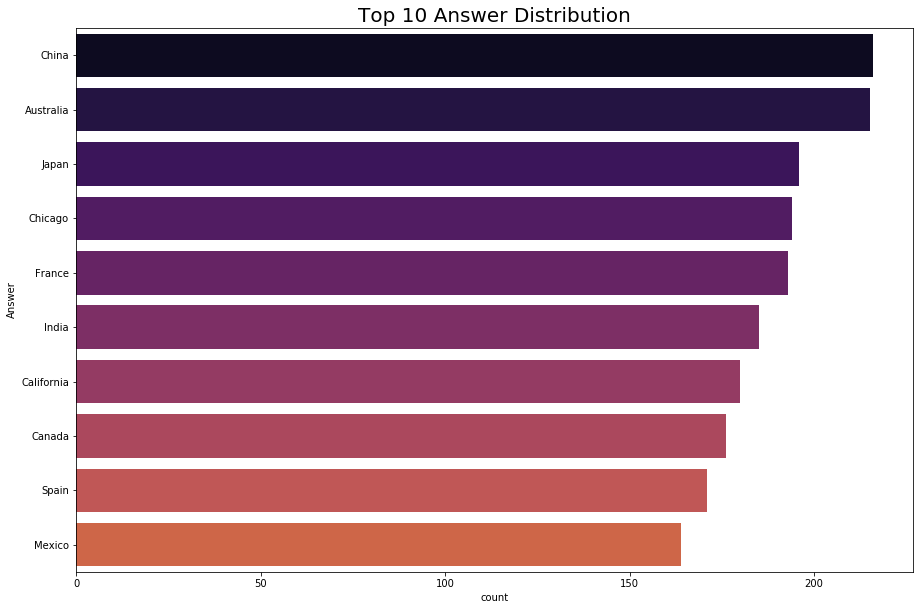

In [13]:
# Visualize top 10 Answers:
mask = df['Answer'].map(lambda x: x in top_10.index.tolist())

sns.countplot(y='Answer', data=df[mask], palette=sns.color_palette('inferno',15),order=top_10.index.tolist())
plt.gcf().set_size_inches(15,10)
plt.title('Top 10 Answer Distribution',size=20)

In [14]:
# Let's do the same with Questions:

top_10_Q = df['Question'].value_counts()
print(top_10_Q.head())

# Wait a sec! This is interesting...
# Seems like I should get rid of some more rows because some of the clues are audio/video.

[audio clue]    17
[video clue]    14
(audio clue)     5
[filler]         5
Greenland        4
Name: Question, dtype: int64


In [15]:
# drop them with masks
mask1 = df[df['Question'] == ('[audio clue]')]
mask2 = df[df['Question'] == ('[video clue]')]
mask3 = df[df['Question'] == ('[filler]')]
mask4 = df[df['Question'] == ('(audio clue)')]

df.drop(mask1.index, inplace = True) 
df.drop(mask2.index, inplace = True)
df.drop(mask3.index, inplace = True)
df.drop(mask4.index, inplace = True)
df.shape

(216887, 8)

In [16]:
# Let's try check out categories:

top_10_C = df['Category'].value_counts()[:10]
print(top_10_C)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64


Text(0.5, 1.0, 'Top 10 Categories')

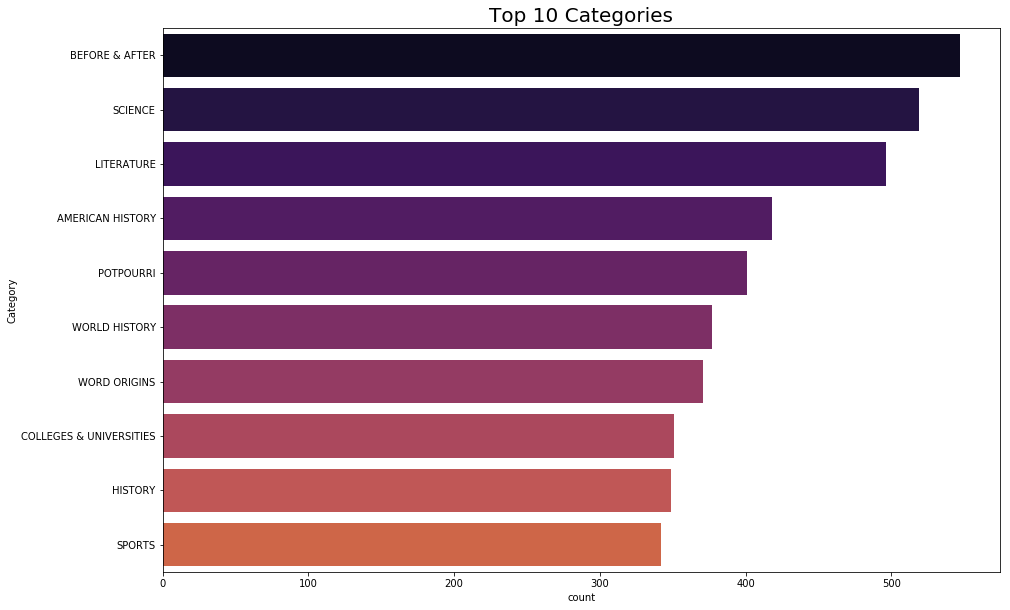

In [17]:
# Visualize top 10 Categories: 
mask = df['Category'].map(lambda x: x in top_10_C.index.tolist())

sns.countplot(y='Category', data=df[mask], palette=sns.color_palette('inferno',15),order=top_10_C.index.tolist())
plt.gcf().set_size_inches(15,10)
plt.title('Top 10 Categories',size=20)

## Category Titles and Thoughts on the Dataset

There are many category titles that contextualize answers and act as clues. There are 216930 questions in this dataset and 27995 unique categories. Although some category titles repeat themselves, I would like to further synthesize these contextual category titles into larger categories. 

My hypothesis for accomplishing this is by picking out key question words such as, "How", "Where", "When", "What", "Who". Although there are finer ways to categorize questions, this would be a good start. I might also explore by grouping key words because it might hint at similar topics.



## Pre-processing


In [18]:
# Use BeautifulSoup to get rid of html artifacts.

df['processed'] = df['Question'].map(lambda x: BeautifulSoup(x,'lxml').get_text())

In [19]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
df['processed'] = [lemmatizer.lemmatize(word) for word in df['processed']]

# lower case
df['processed'] = [word.lower() for word in df['processed']]
df['Answer'] = [word.lower() for word in df['Answer']]

# get rid of all special characters using Regex
df['processed'] = [re.sub('[^A-Za-z0-9]+', ' ', word) for word in df['processed']]
df['Answer'] = [re.sub('[^A-Za-z0-9]+', ' ', word) for word in df['Answer']]

In [20]:
# double check:
print('old:', df['Question'][29], '\n')
print('new:', df['processed'][29])
print('answer:', df['Answer'][29])

old: <a href="http://www.j-archive.com/media/2004-12-31_DJ_23.mp3">Beyond ovoid abandonment, beyond ovoid betrayal... you won't believe the ending when he "Hatches the Egg"</a> 

new: beyond ovoid abandonment beyond ovoid betrayal you won t believe the ending when he hatches the egg 
answer: horton


In [21]:
# Save cleaned questions 
np.savetxt('jeopardy.txt', df['processed'], fmt='%s', delimiter="\t")  

In [22]:
# more EDA on the vectors, 
# logreg, CART/boosting model, 

## Count Vectorization on Words.

Before I can use different clustering methods, I need to vectorize my questions. Although I will use both CountVectorizer and TFIDF, I decided to use CountVectorizer first because I think the common question words matter in this case. If I add more weight to unique words using TFIDF, I might discount the importance of common question words present in the questions. 

Furthermore, words that are prominent might cluster into a topic as well. I will lose this ability if I use TFIDF.

On a side note, I realize CountVectorizing on words is naive but I wanted to see how a basic model looks.

In [23]:
question_list = list(df['processed']) 

### CVEC histogram view

In [24]:
cvec = CountVectorizer(max_features=30000)
X_text = cvec.fit_transform(df['Question'])
X_text

<216887x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 2844181 stored elements in Compressed Sparse Row format>

In [25]:
X_text = pd.DataFrame(X_text.toarray(), columns=cvec.get_feature_names())
X_text_sample = X_text.sample(12000)

In [26]:
X_text_sum = X_text_sample.sum()

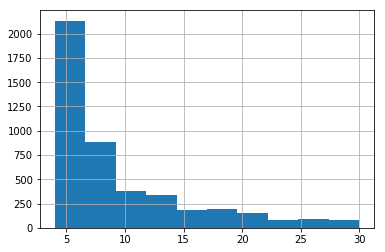

In [27]:
X_text_sum[X_text_sum.between(4, 30)].hist()

In [28]:
#X_text_sum[X_text_sum > 0].sort_values(ascending = False)

In [29]:
vec = CountVectorizer(min_df = .1, max_df = .75)
question_vec = vec.fit_transform(question_list)
question_vec_df = pd.DataFrame(question_vec.toarray(), columns = vec.get_feature_names())
question_vec_array = question_vec.toarray()

In [30]:
question_vec_df.head()

,for,in,is,it,of,on,the,this,to,was
0,2,0,0,0,1,0,1,1,0,1
1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,3,0,1,1,0,0
3,0,1,0,0,0,1,1,1,0,0
4,0,0,0,0,5,0,3,0,0,0


In [31]:
# I have to create a dense matrix to run it through PCA.
# I need to reduce dimensionality to run it through KMeans and DBSCAN.

dense_vec = [[b for b in sub] for sub in question_vec_array]

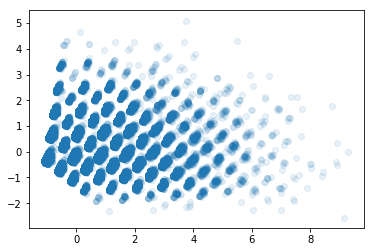

In [32]:
# Visualize PCA that's from CountVectorizer

pca = PCA(n_components=2).fit(dense_vec)
data2D = pca.transform(dense_vec)
plt.scatter(data2D[:,0], data2D[:,1], alpha = .1)
plt.show()  

In [33]:
# PCA'd features in a dataframe to put KMeans centroids on it.

data2D_df = pd.DataFrame(data2D)
data2D_df.head()

,0,1
0,0.342123,-0.511505
1,-0.210877,-0.310657
2,1.308058,-0.418761
3,0.017835,0.731937
4,3.755074,-2.146939


# CountVec Clustering 

### KMeans

In [34]:
# initialize kmeans 10, 50, 100
kmeans_10 = KMeans(n_clusters = 10)
kmeans_50 = KMeans(n_clusters= 50)
kmeans_100 = KMeans(n_clusters= 100)

In [35]:
# fit kmeans 
model_10 = kmeans_10.fit(data2D) 
model_50 = kmeans_50.fit(data2D)
model_100 = kmeans_100.fit(data2D)

In [36]:
# load cluster centers:
clusters_10 = model_10.cluster_centers_
clusters_50 = model_50.cluster_centers_ 
clusters_100 = model_100.cluster_centers_


In [37]:
# transform cluster centers in to dataframe

centroids_10 = pd.DataFrame(clusters_10)
centroids_50 = pd.DataFrame(clusters_50)
centroids_100 = pd.DataFrame(clusters_100)

In [38]:
# apply centroid distance class to data2D_df

data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

data2D_df['nearest_50'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_50.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

data2D_df['nearest_100'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_100.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

### KMeans 10, 50, 100 clustered questions


In [39]:
# grab and use the index of the nearest_10, nearest_50,nearest_100 class so I can use it on the original df.

kmeans10_cluster_one = data2D_df[data2D_df['nearest_10'] == 9].index
kmeans50_cluster_one = data2D_df[data2D_df['nearest_50'] == 49].index
kmeans100_cluster_one = data2D_df[data2D_df['nearest_100'] == 99].index

kmeans50_cluster_48 = data2D_df[data2D_df['nearest_50'] == 48].index

In [44]:
# The clustering isn't good. The questions do not cluster well. 

# Since it didn't cluster well, I will move on to KMeans with 50 centroids to see if it does any better.
for i in kmeans100_cluster_one:
    print('KMeans 10 cluster one:', df['Question'][i])

KMeans 10 cluster one: (<a href="http://www.j-archive.com/media/2012-01-19_DJ_27.jpg" target="_blank">Sarah of the Clue Crew shows a bunch of jar-preserved specimens.</a>)  Butterflies, centipedes, scorpions, spiders, crabs, lobsters--these & millions of other creepy crawlers belong to this phylum that makes up more than 80% of all animal species, from the Greek for "joint foot"
KMeans 10 cluster one: A function's domain is the set of possible values of x; this is the set of possible values of y
KMeans 10 cluster one: In 1887 Ethiopia's Menelik II founded this city in the Entoto Mountains
KMeans 10 cluster one: Meryl Streep played Laurey in her high school production of this Rodgers & Hammerstein musical
KMeans 10 cluster one: It sounds like a sailors' surplus store, but this clothing store chain is a branch of GAP, Inc.
KMeans 10 cluster one: From Spanish, the name of this Texas city refers to the yellowish banks of a nearby stream
KMeans 10 cluster one: James Thurber's story of this 

In [ ]:
# KMeans 50 didn't cluster questions well either... moving to KMeans 100 
# for i in kmeans50_cluster_one:
#     print('KMeans 50 cluster one:', df['Question'][i])

# I tried cluster no.48 because most of them were outliers and I wanted to see what kind of questions those were.
# for i in kmeans50_cluster_48:
#     print('KMeans 50 cluster 48:', df['Question'][i]) 

In [ ]:
# for i in kmeans100_cluster_one:
#     print('KMeans 100 cluster one:', df['Question'][i])

In [45]:
# apply centroid distance class to sample

data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), 
                                                                   axis =1).argmin(), axis = 1)

data2D_df['nearest_50'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_50.sub(x[[0,1]]),
                                                                   axis =1).argmin(), axis = 1)

data2D_df['nearest_100'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_100.sub(x[[0,1]]),
                                                                    axis =1).argmin(), axis = 1)

In [46]:
data2D_df.head()

,0,1,nearest_10,nearest_50,nearest_100
0,0.342123,-0.511505,2,11,29
1,-0.210877,-0.310657,9,2,41
2,1.308058,-0.418761,5,1,16
3,0.017835,0.731937,3,5,66
4,3.755074,-2.146939,8,14,70


### KMeans 10, 50, 100 Visualization

IndexError: index 10 is out of bounds for axis 0 with size 10

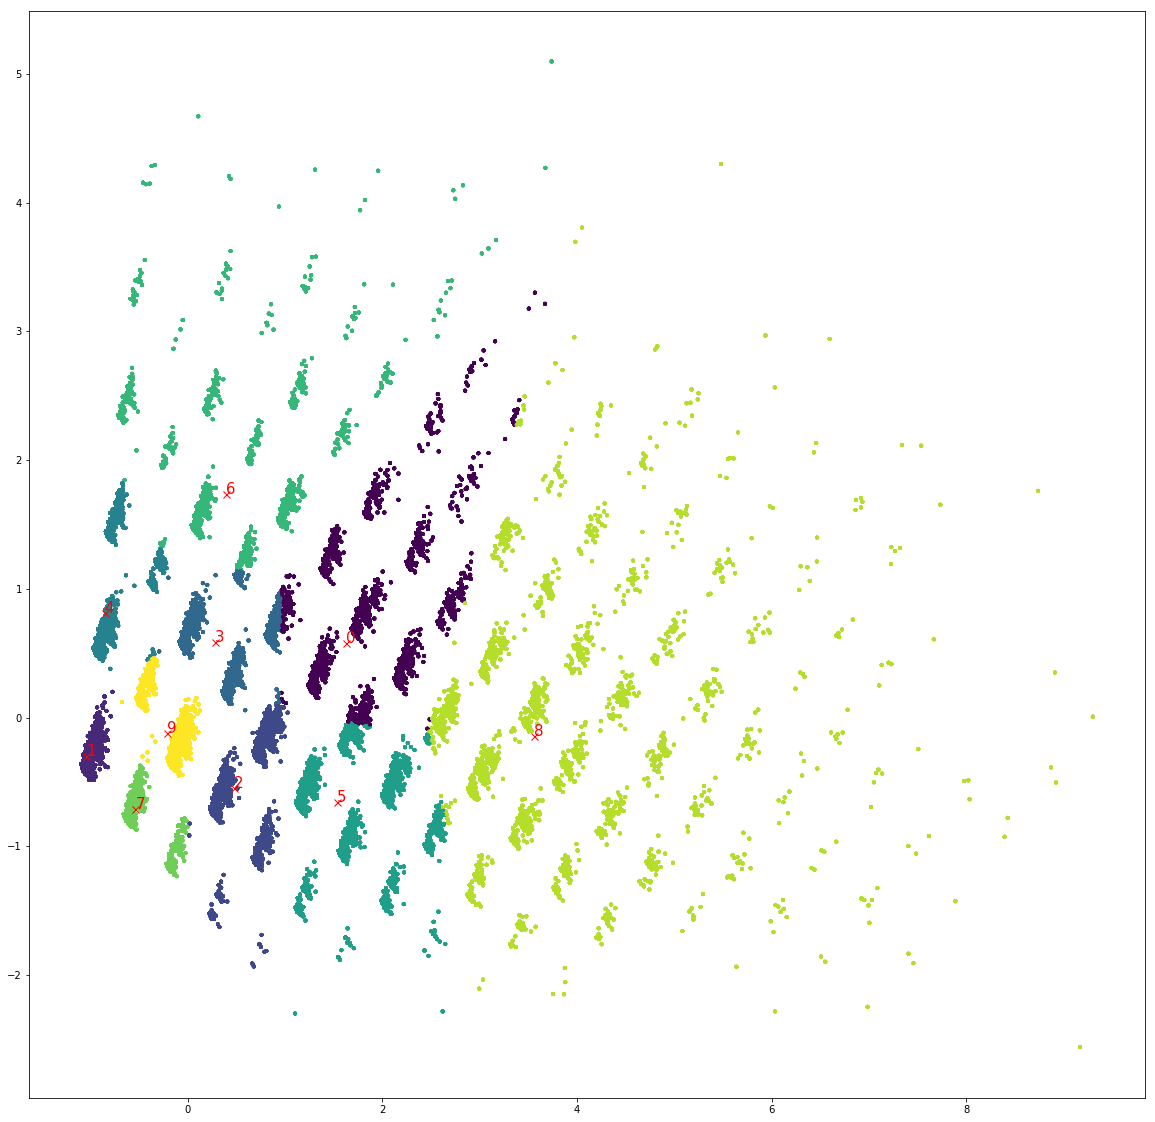

In [50]:
# kmeans 10 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_10'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_10'])
    
    # centroid is kmeans center
    centroid = kmeans_10.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_10'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

IndexError: index 50 is out of bounds for axis 0 with size 50

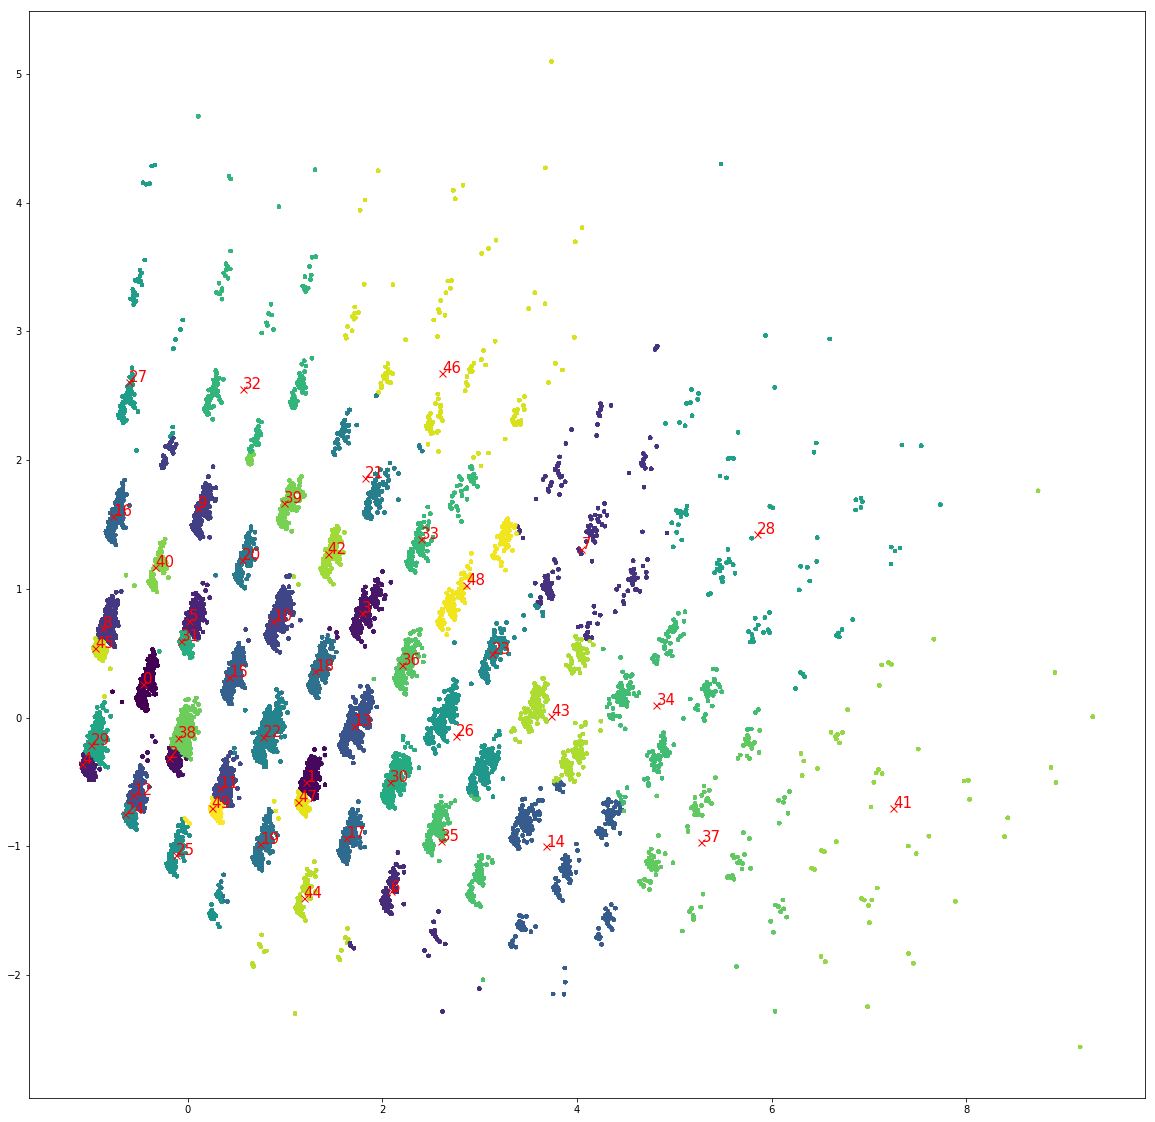

In [51]:
# kmeans 50 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_50'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_50'])
    
    # centroid is kmeans center
    centroid = kmeans_50.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_50'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

IndexError: index 100 is out of bounds for axis 0 with size 100

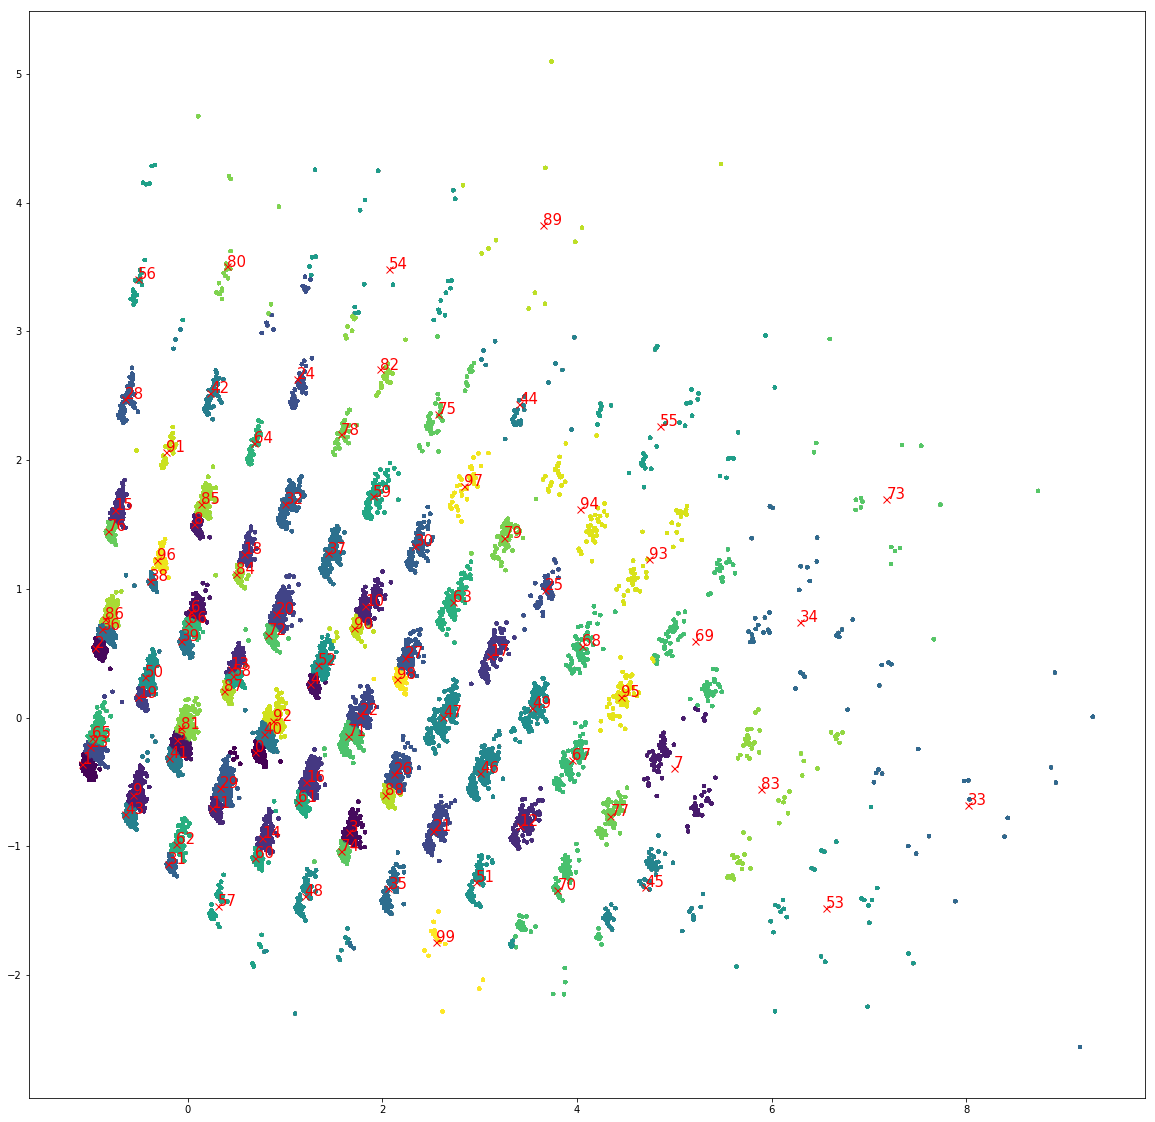

In [52]:
# kmeans 100 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_100'] == i]
    plt.scatter(data2D_df[0], data2D_df[1], s=8, alpha = .3,  c = data2D_df['nearest_100'])
    
    # centroid is kmeans center
    centroid = kmeans_100.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_100'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

## KMeans Observations:

Visually checking KMeans with 10, 50, 100 centroids showed that none of them did a satisfactory job of grouping (especially the outliers). KMeans with 100 centroids is interesting in that there are many centroids within a dense cluster but it isn't too informative.

This is further supported 

### DBSCAN with eps = 0.1, min sample =10

Data2D_df is too big for my computer to compute. Thus, I had to sample 10,000 observations. 

In [53]:
# create an array from data2D_df to sample from. 
data2D_df = pd.DataFrame(data2D)
data2D_df['class'] = data2D_df.index

data2D_array = data2D_df.values

#use np.random.choice(30000) on data2D for sampling/visualization purposes.

sample = data2D_array[np.random.randint(data2D_array.shape[0], size=30000), :]
sample = pd.DataFrame(sample)

#rename '2' to index
sample = sample.rename(columns={2: 'index from data2D_df'})
sample.head()

,0,1,index from data2D_df
0,-1.094660,-0.361274,198321.0
1,-1.094660,-0.361274,210530.0
2,2.436042,-0.984429,57268.0
3,-0.654983,-0.748777,62237.0
4,-0.870931,0.718804,14946.0


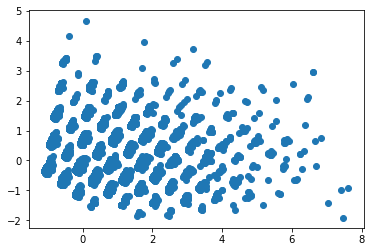

In [54]:
# visually check sample
plt.scatter(sample[0], sample[1])

In [55]:
# convert data2D_df to array to use it with DBSCAN
sample_array = sample[[0,1]].values
sample_array

array([[-1.0946596 , -0.361274  ],
       [-1.0946596 , -0.361274  ],
       [ 2.43604247, -0.984429  ],
       ...,
       [ 0.68332545,  2.16283814],
       [ 0.13945204,  1.71939965],
       [ 0.30139257, -0.54705049]])

In [56]:
# Initialize DBSCAN

db = DBSCAN(eps=0.1, min_samples=10).fit(sample_array)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [57]:
# create a labels class for visualization

sample['db_labels'] = db.labels_

In [58]:
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [59]:

sample_df = pd.DataFrame(sample_array)

Text(0.5, 1.0, 'DBSCAN with PCA')

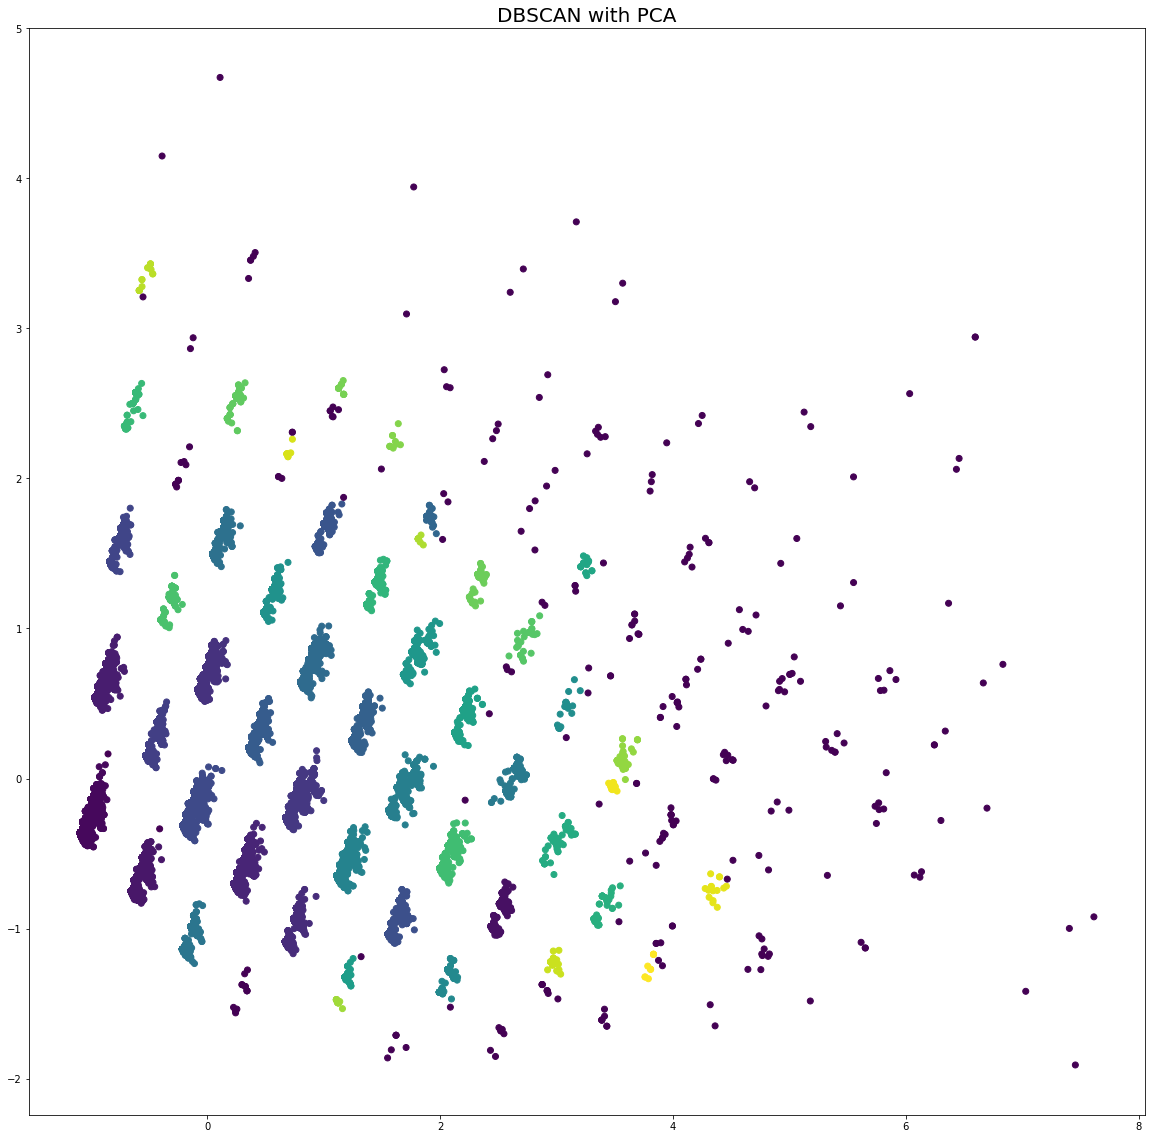

In [63]:
# Visualize DBScan with epsilon = 0.2, min_samples = 10:
fig = plt.figure(figsize=(20,20))
plt.scatter(sample[0], sample[1], c = db.labels_)
plt.title('DBSCAN with PCA', fontsize = '20')

In [61]:
df.shape

(216887, 9)

In [64]:
# Qualitative Metric:
# I tried different db_labels and none of them clustered too well.

zero_index = sample[sample['db_labels'] == 45].index

for i in zero_index:
    print(df['Question'][i])

Quang Tri City; the cavalry was sent!
The Motion Picture Association of America says this cost producers, theater owners, etc. $18.2 billion in 2005
(I'm Hall of Fame running back Tony Dorsett)  This man was my coach for my first 11 seasons in the NFL
In the early '70s East German spy Gunter Guillaume infiltrated the office of this West German chancellor
This designer's Y-line dress, seen here, highlighted a show on the year 1955
In 1794 this hero of Trafalgar lost the sight in his right eye due to a wound suffered while taking Calvi, Corsica
Banana & teaberry are among more than 30 flavors of this old-fashioned sweet sold at Shriver's in Ocean City, New Jersey
This Asian carnivore is the largest member of the cat family & the only big cat with striped fur
This British author wrote "The War in the Air" as well as "The War of the Worlds"
Seen here, these trousers bear the name of the island where they first became popular


## TFIDF Clustering on Sample Size = 20000

In [65]:
# due to computational reasons, I decided to take 20,000 random samples from the dataset

question_list_sample = random.sample(question_list, 20000)
question_list_sample[:10]

['fiery nickname of head nurse margaret houlihan',
 'in 1946 norway s trygve lie became 1st to hold this post',
 'kurtz cuts loose when cut off from humanity in this 1902 tale',
 'lady amalia the wife of this discoverer of penicillin was a member of greece s parliament',
 'william jennings bryan twice ',
 'among these creatures males of the black species share egg warming duties but trumpeter males don t',
 'this term for an awkward unforeseen event comes from the french for against time ',
 'elected to the hall of fame in 1966 his lifetime batting average was 344',
 'bones dating from mesolithic times indicate that this wolf relative was the first domesticated animal',
 'in 2001 elton john courted controversy when he sang a duet with this rapper at the grammys']

In [66]:
# initialize TFIDF and convert output to array.

tfidf = TfidfVectorizer(stop_words = "english")
question_tfidf = tfidf.fit(question_list_sample)

data2D_df  = pd.DataFrame(tfidf.transform(question_list_sample).todense(),
                   columns = tfidf.get_feature_names(),
                   )
data2D_df.shape

(20000, 28684)

In [67]:
# dimensionality reduction using PCA

pca = PCA(n_components =2).fit(data2D_df)
data2D_df = pca.transform(data2D_df)
data2D_df

array([[-0.00906576, -0.00627397],
       [-0.01080353, -0.01279877],
       [-0.01275562, -0.00895308],
       ...,
       [-0.02714919, -0.0061722 ],
       [ 0.00125568, -0.00933642],
       [ 0.02019392,  0.00015547]])

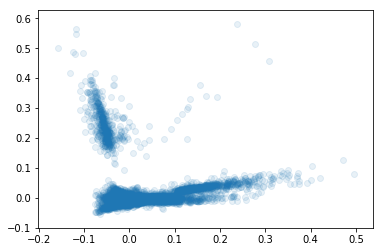

In [68]:
# visualize PCA

plt.scatter(data2D_df[:,0], data2D_df[:,1], alpha = .1)
plt.show()  

In [69]:
# convert data2D_df from array to dataframe
data2D_df = pd.DataFrame(data2D_df)
data2D_df.head()

,0,1
0,-0.009066,-0.006274
1,-0.010804,-0.012799
2,-0.012756,-0.008953
3,-0.013519,-0.005047
4,-0.007327,-0.011076


## KMeans 10

In [70]:
# data2D_array = data2D_df[[0,1]].values
# data2D_array

In [71]:
kmeans_10 = KMeans(n_clusters = 10) 
model_10 = kmeans_10.fit(data2D_df) 
clusters_10 = model_10.cluster_centers_ 
centroids_10 = pd.DataFrame(clusters_10)

In [72]:
# apply class by distance 
data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

In [101]:
kmeans10_cluster_one = data2D_df[data2D_df['nearest_10'] == 9].index

In [102]:
# KMeans 10 question group 9 doesn't seem to be grouping too well.

for i in kmeans10_cluster_one:
    print(df['Question'][i])

Built in 312 B.C. to link Rome & the South of Italy, it's still in use today
No. 1: Lettered in hoops, football & lacrosse at Syracuse & if you think he couldn't act, ask his 11 "unclean" buddies
Karl led the first of these Marxist organizational efforts; the second one began in 1889
1939 Oscar winner: "...you are a credit to your craft, your race and to your family"
The Kirschner brothers, Don & Bill, named this ski company for themselves & the second-highest mountain
Revolutionary War hero: "His spirit is in Vermont now"
In the seat pocket you'll find the catalog called "Sky" this, with must-haves like a solar-powered patio umbrella
This 1797 imbroglio began when 3 French agents demanded a huge bribe from U.S. diplomats
Peaches are more than 80% this compound
Small, slender missile thrown at a board in a game
This island in the South Pacific is named for the day of its discovery, a religious holiday
Parts of the Arabian and Libyan deserts are found in this African country
This device

As you might "Expect", this book, first published in 1984, is the top pregnancy guide for moms-to-be
By its derivation the only thing in an arboretum should be these, no shrubs or other plants
You may know it as the name of a green melon; it's also the term for the sweet, sticky stuff secreted by aphids
In 1920 he married the Mary who was "America's Sweetheart"
Used to remove small twigs & stems, these shears may be anvil or bypass
The British burned Washington, D.C. as revenge for the American burning of York, Canada, now this city
His wife Mary "gave birth" to a monster, Frankenstein's
The family rosaceae includes roses & these fruits, such as Jonathans
A multi-unit structure in which the whole building is jointly owned by all the residents
Gichin Funakoshi, an Okinawan master, popularized this martial art in Japan early in the 20th century
It's the scientific name of the only extant species of the primate family Hominidae
Because his boss wouldn't let him carry a loaded gun, this bu

KeyError: 19445

In [75]:
#add index to data2D_df

data2D_df['index'] = data2D_df.index

IndexError: index 10 is out of bounds for axis 0 with size 10

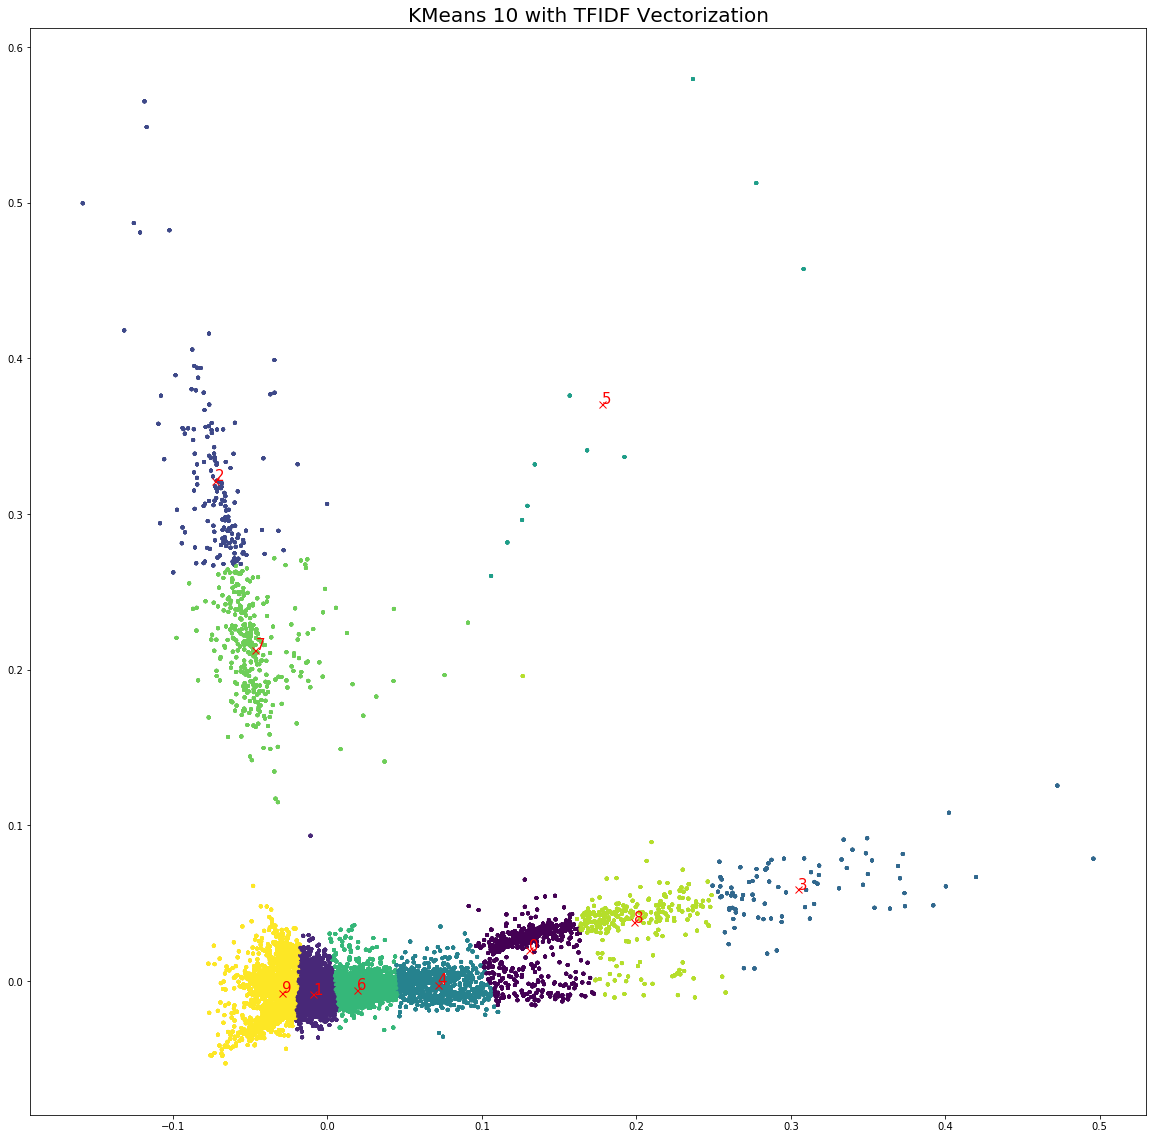

In [142]:
# visually check 

plt.figure(figsize=(20,20))
plt.title("KMeans 10 with TFIDF Vectorization", fontsize = 20)

for i in range(0, 20000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_10'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_10'])
    
    # centroid is kmeans center
    centroid = kmeans_10.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_10'])
    plt.annotate(str(i),centroid,size=15, color = 'red')


## KMeans with TFIDF Observations

Visualizing KMeans with 50 centroids shows an excessive concentration on one spot so I didn't run KMeans 100. When I checked how the questions were grouping, it didn't perform that well either. I will be moving on to DBSCAN.

## DBSCAN

In [134]:
# make an array from data2D_df (TFIDF and sample = 20,000)

data2D_array = data2D_df[[0,1]].values

In [135]:
# initialize DBSCAN

db = DBSCAN(eps=0.005, min_samples= 7).fit(data2D_array)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


In [137]:
# create a labels class for visualization

data2D_df['db_labels'] = db.labels_
#sample_df['db_labels'] = db.labels_

In [138]:
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# convert array into dataframe
sample_df = pd.DataFrame(data2D_array)


Text(0.5, 1.0, 'DBSCAN with TFIDF Vectorization')

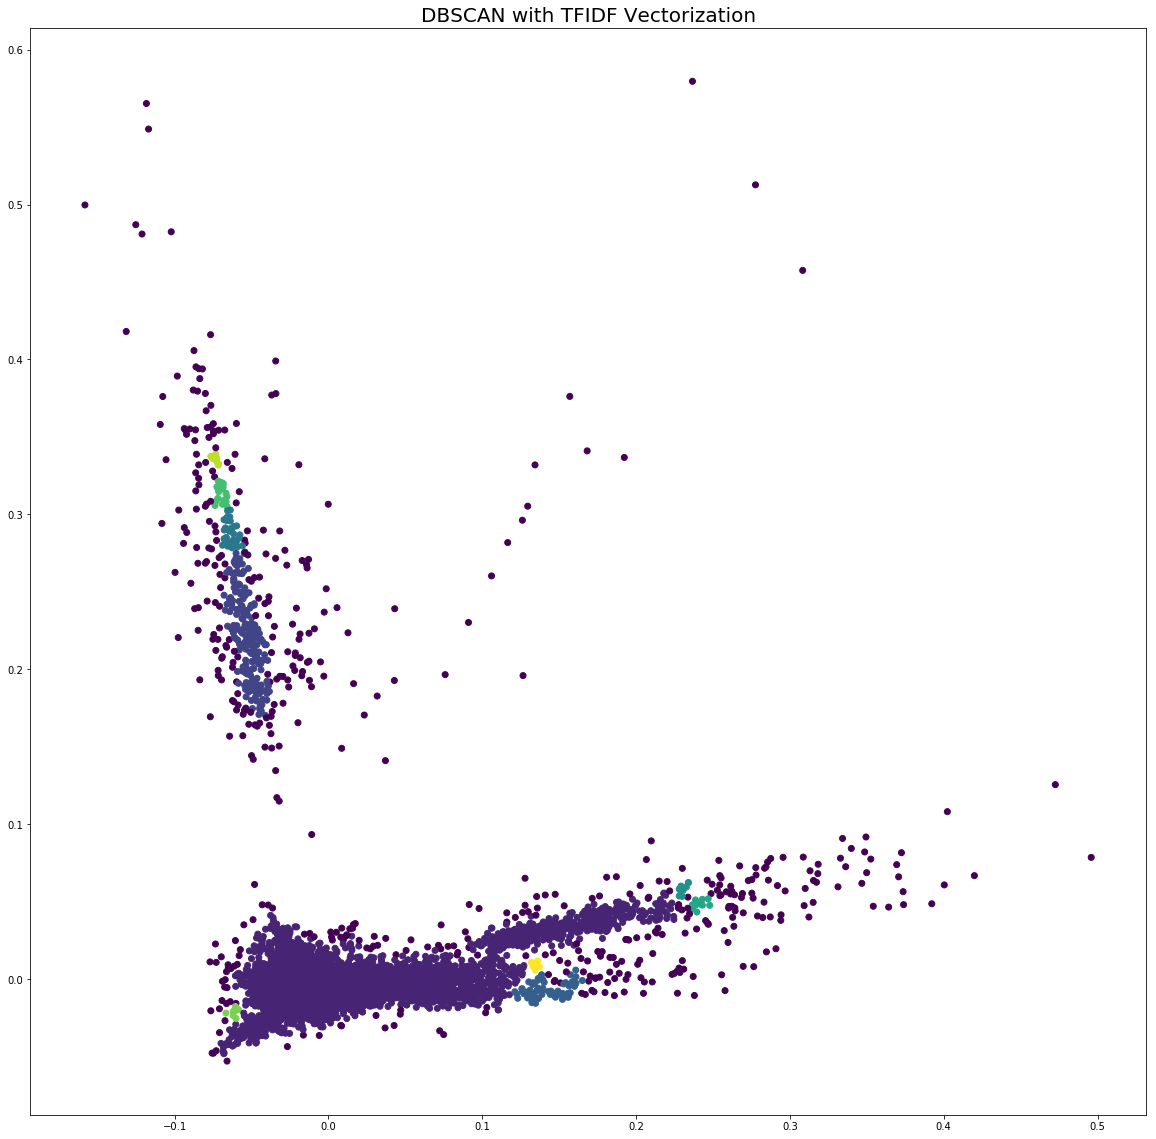

In [143]:
# Visualize DBSCAN with epsilon = 0.2, min_samples = 10:
fig = plt.figure(figsize=(20,20))
plt.scatter(data2D_df[0], data2D_df[1], c = db.labels_)
plt.title("DBSCAN with TFIDF Vectorization", fontsize = 20)

In [145]:
# heuristic check:

zero_index = data2D_df[data2D_df['db_labels'] == 3].index

for i in zero_index:
    print(df['Question'][i])

This "Urban" store is the parent company of Anthropologie
Belize City, Guatemala City, Panama City
State whose abbreviation is also a cabinet department that was formed in 1989
Ferdinand von Lindemann proved the problem of "squaring" this with compass & ruler was impossible
Of Hawaii's 8 main islands, this one receives the lion's share of the tourist dollars
M. Night Shyamalan wrote & directed this creepy Bruce Willis-Haley Joel Osment film
The name Zog is not as much in vogue as it once was, when King Zog I ruled this European country
They're the two main ingredients in a Cape Codder cocktail
TV host seen here on the cover of Mad Magazine
1973: "A Little Night Music"
In 1533 this Venetian was made court painter by Emperor Charles V, who also ennobled him
March 1st is the feast day of this patron saint of Wales
A myocardial infarction, better known as this, is a common reason for ICU admission
Chinese or Malay: This tomato condiment that's put on French fries
1994: "Just marking my ter

## DBSCAN observation

DBSCAN on TFIDF extracted data isn't as useful because the observations are in a very tight cluster already. Even with a really low epsilon, the cluster groups is not particularly useful. Qualitative check also shows that the questions are not really related.

After checking heuristically, it is apparent that the questions are not related.

## Doc2Vec  (Model initialization and qualitative check)

In [146]:
# Transform pre-processed Jeopardy questions into a list 

with open('jeopardy.txt') as f:
    data = f.readlines()
    
doc2vec_data = []
for line in data:
    doc2vec_data.append(line)

len(doc2vec_data) # check everything was transformed correctly.

216887

In [147]:
# write another text file from doc2vec_data list

File = open('doc2vec_data.txt', 'w')

for item in doc2vec_data:
    File.write('%s' % item)

In [148]:
#Initialize and train model

sentences = gensim.models.doc2vec.TaggedLineDocument('doc2vec_data.txt')
model = gensim.models.doc2vec.Doc2Vec(sentences, size = 200, window = 10, min_count = 5, iter = 50, workers = 5)

/Users/queenbee/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/queenbee/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [149]:
# Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

df['processed_text'] = df['Question'].map(lambda x: gensim.utils.simple_preprocess(x))

In [150]:
# Check most similar questions

sims = model.docvecs.most_similar(2)

print(sims)

[(34328, 0.8365196585655212), (160724, 0.8149013519287109), (187263, 0.8113768100738525), (203079, 0.8103482723236084), (19791, 0.8072080016136169), (110634, 0.8054571151733398), (204814, 0.8024399876594543), (169761, 0.7970010042190552), (41498, 0.7947109937667847), (18272, 0.7944686412811279)]


/Users/queenbee/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [151]:
# Heuristic check

print('original question:', df['Question'].iloc[2], '\n', 'ANSWER:', df['Answer'].iloc[2])
for i in sims:
    print('question index', i[0],":" , df['Question'].iloc[i[0]], '\n', 'ANSWER:', df['Answer'].iloc[i[0]])

# Seems like the questions were grouped by 'cities'.

original question: The city of Yuma in this state has a record average of 4,055 hours of sunshine each year 
 ANSWER: arizona
question index 34328 : City-state ruled by Pericles 
 ANSWER: athens
question index 160724 : "The Nickel City" 
 ANSWER: buffalo
question index 187263 : Following Oklahoma City, this city of about 400,000 is the second most populous in the state 
 ANSWER: tulsa
question index 203079 : Guatemala City, Panama City, Mexico City 
 ANSWER: panama city
question index 19791 : The city of High Point in this state is a high point for shoppers; it's the "Home Furnishings Capital of the World" 
 ANSWER: north carolina
question index 110634 : Panama City, Guatemala City, Mexico City 
 ANSWER: mexico city
question index 204814 : Barrow is the northernmost city in this state & thus the United States 
 ANSWER: alaska
question index 169761 : City name of the state bird seen here 
 ANSWER: baltimore oriole
question index 41498 : This E.M. Forster novel is set in the fictional ci

In [152]:
# most similar check: 

print(model.most_similar(positive = ['america', 'football'], negative = ['china']))

[('nba', 0.42308151721954346), ('nfl', 0.4182155132293701), ('basketball', 0.39733409881591797), ('league', 0.3916044235229492), ('music', 0.39004889130592346), ('baseball', 0.3826827108860016), ('qb', 0.37180036306381226), ('hockey', 0.36778002977371216), ('games', 0.36470016837120056), ('american', 0.3607267737388611)]


/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  app.launch_new_instance()


In [153]:
# most similar (cosmul) check:
# CosMul amplifies the differences between small quantities and reduces the differences between larger ones.

print(model.most_similar_cosmul(positive= ['america', 'football'], negative = ['china']))

[('nba', 0.8609136343002319), ('nfl', 0.8496574759483337), ('music', 0.8359246850013733), ('qb', 0.8288096785545349), ('league', 0.8255208730697632), ('basketball', 0.8254998922348022), ('hockey', 0.8078839182853699), ('baseball', 0.8036937713623047), ('games', 0.8032094836235046), ('scoring', 0.796829104423523)]


/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


## Doc2Vec (PCA and t-SNE dimension reduction visualization)

In [154]:
# Grab vectors for Doc2Vec model above
# The raw vectors array of words in a Doc2Vec model is available in model.wv.syn0

word_vecs = model.wv.syn0

/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


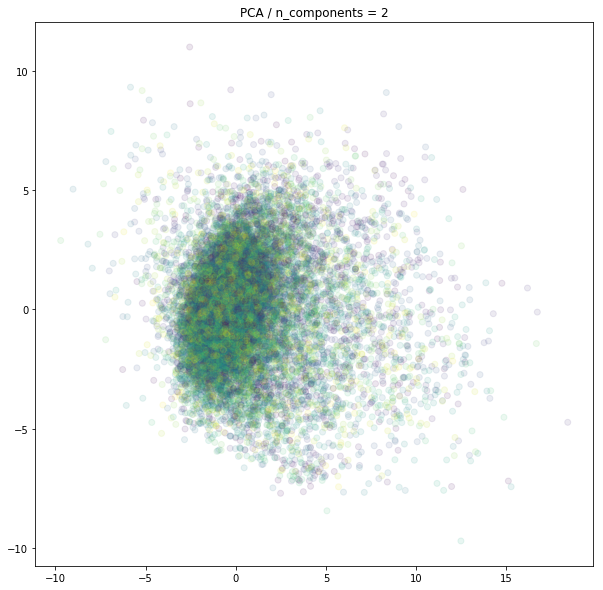

In [155]:
# used 2 dimensional PCA on Doc2Vec's vector
# not clustering too well.
# try many components and use the first two.

# It doesn't tell me anything.

# get topic keys
pca_keys = []
for i in range(word_vecs.shape[0]):
    pca_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
pca = PCA(n_components = 2).fit(word_vecs)
data2D = pca.transform(word_vecs)
plt.scatter(data2D[:,0], data2D[:,1], alpha = .1, c = pca_keys)
plt.title("PCA / n_components = 2")
plt.show()  

In [156]:
# try T-SNE and see if it clusters better

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca', perplexity= 50)
tsne = tsne_model.fit_transform(word_vecs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 27965 samples in 0.550s...
[t-SNE] Computed neighbors for 27965 samples in 400.729s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27965
[t-SNE] Computed conditional probabilities for sample 2000 / 27965
[t-SNE] Computed conditional probabilities for sample 3000 / 27965
[t-SNE] Computed conditional probabilities for sample 4000 / 27965
[t-SNE] Computed conditional probabilities for sample 5000 / 27965
[t-SNE] Computed conditional probabilities for sample 6000 / 27965
[t-SNE] Computed conditional probabilities for sample 7000 / 27965
[t-SNE] Computed conditional probabilities for sample 8000 / 27965
[t-SNE] Computed conditional probabilities for sample 9000 / 27965
[t-SNE] Computed conditional probabilities for sample 10000 / 27965
[t-SNE] Computed conditional probabilities for sample 11000 / 27965
[t-SNE] Computed conditional probabilities for sample 12000 / 27965
[t-SNE] Computed conditional probabilities for 

In [157]:
# random initialization
tsne_model2 = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, learning_rate = 100, init='pca', perplexity= 50)
tsne2 = tsne_model2.fit_transform(word_vecs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 27965 samples in 0.470s...
[t-SNE] Computed neighbors for 27965 samples in 354.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27965
[t-SNE] Computed conditional probabilities for sample 2000 / 27965
[t-SNE] Computed conditional probabilities for sample 3000 / 27965
[t-SNE] Computed conditional probabilities for sample 4000 / 27965
[t-SNE] Computed conditional probabilities for sample 5000 / 27965
[t-SNE] Computed conditional probabilities for sample 6000 / 27965
[t-SNE] Computed conditional probabilities for sample 7000 / 27965
[t-SNE] Computed conditional probabilities for sample 8000 / 27965
[t-SNE] Computed conditional probabilities for sample 9000 / 27965
[t-SNE] Computed conditional probabilities for sample 10000 / 27965
[t-SNE] Computed conditional probabilities for sample 11000 / 27965
[t-SNE] Computed conditional probabilities for sample 12000 / 27965
[t-SNE] Computed conditional probabilities for 

Text(0.5, 1.0, 'perplexity = 30 / PCA/ Learning Rate = 200')

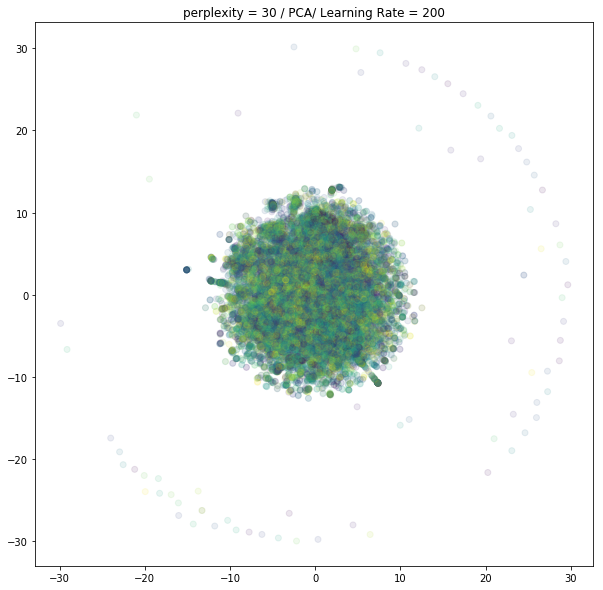

In [158]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 30 used with PCA)


tsne_keys = []
for i in range(word_vecs.shape[0]):
    tsne_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
plt.scatter(x= tsne[:, 0], y = tsne[:, 1], alpha = 0.1, c = tsne_keys)
plt.title(label = "perplexity = 30 / PCA/ Learning Rate = 200")

Text(0.5, 1.0, 'perplexity = 50 / PCA / Learning Rate = 200')

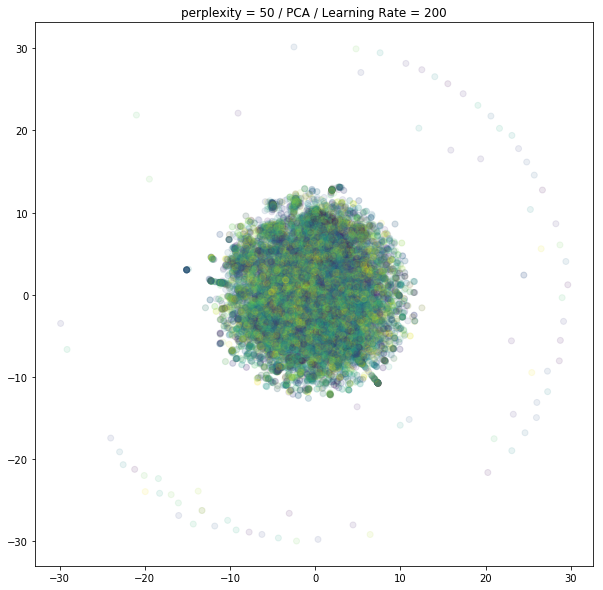

In [159]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 50 used with PCA)

tsne_keys = []
for i in range(word_vecs.shape[0]):
    tsne_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
plt.scatter(x= tsne[:, 0], y = tsne[:, 1], alpha = 0.1, c = tsne_keys)  
plt.title(label = "perplexity = 50 / PCA / Learning Rate = 200")

Text(0.5, 1.0, 'perplexity = 50 / PCA / Learning Rate = 100')

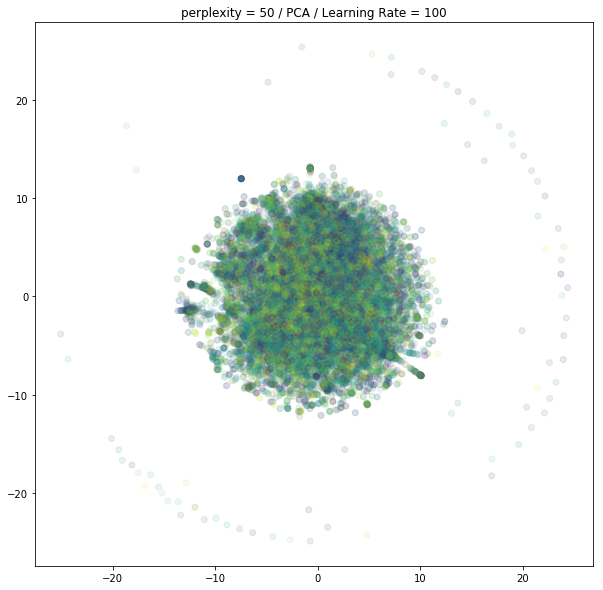

In [160]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 50 used with PCA)

tsne2_keys = []
for i in range(word_vecs.shape[0]):
    tsne2_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))   
plt.scatter(x= tsne2[:, 0], y = tsne2[:, 1], alpha = 0.1, c = tsne2_keys)
plt.title(label = "perplexity = 50 / PCA / Learning Rate = 100")

## LDA Visualization with T-SNE

In [161]:
lda_model = LatentDirichletAllocation()
X_topics = lda_model.fit_transform(question_vec)

/Users/queenbee/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [162]:
# HEADS UP! This will take a long time.

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 216887 samples in 2.123s...
[t-SNE] Computed neighbors for 216887 samples in 47.483s...
[t-SNE] Computed conditional probabilities for sample 1000 / 216887
[t-SNE] Computed conditional probabilities for sample 2000 / 216887
[t-SNE] Computed conditional probabilities for sample 3000 / 216887
[t-SNE] Computed conditional probabilities for sample 4000 / 216887
[t-SNE] Computed conditional probabilities for sample 5000 / 216887
[t-SNE] Computed conditional probabilities for sample 6000 / 216887
[t-SNE] Computed conditional probabilities for sample 7000 / 216887
[t-SNE] Computed conditional probabilities for sample 8000 / 216887
[t-SNE] Computed conditional probabilities for sample 9000 / 216887
[t-SNE] Computed conditional probabilities for sample 10000 / 216887
[t-SNE] Computed conditional probabilities for sample 11000 / 216887
[t-SNE] Computed conditional probabilities for sample 12000 / 216887
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 118000 / 216887
[t-SNE] Computed conditional probabilities for sample 119000 / 216887
[t-SNE] Computed conditional probabilities for sample 120000 / 216887
[t-SNE] Computed conditional probabilities for sample 121000 / 216887
[t-SNE] Computed conditional probabilities for sample 122000 / 216887
[t-SNE] Computed conditional probabilities for sample 123000 / 216887
[t-SNE] Computed conditional probabilities for sample 124000 / 216887
[t-SNE] Computed conditional probabilities for sample 125000 / 216887
[t-SNE] Computed conditional probabilities for sample 126000 / 216887
[t-SNE] Computed conditional probabilities for sample 127000 / 216887
[t-SNE] Computed conditional probabilities for sample 128000 / 216887
[t-SNE] Computed conditional probabilities for sample 129000 / 216887
[t-SNE] Computed conditional probabilities for sample 130000 / 216887
[t-SNE] Computed conditional probabilities for sample 131000 / 216887
[t-SNE] Computed con

In [163]:
# tsne_lda to dataframe
tsne_lda_df = pd.DataFrame(tsne_lda)
len(tsne_lda_df)

216887

In [164]:
lda_keys = []
for i in range(X_topics.shape[0]):
    lda_keys +=  X_topics[i].argmax(),

len(lda_keys)

216887

In [165]:
# create class for 

lda_keys_df = pd.DataFrame(lda_keys)
lda_keys_df = lda_keys_df.rename(columns = {0: 'class'})

In [166]:
# merge tsne_lda_df with the likely topic for each question:

df2 = pd.concat([tsne_lda_df, lda_keys_df], axis=1)
df2.head()

,0,1,class
0,31.631237,-12.994871,5
1,-0.193324,-34.925030,8
2,33.985725,-30.510685,0
3,-4.503332,26.835888,3
4,41.685192,17.067120,9


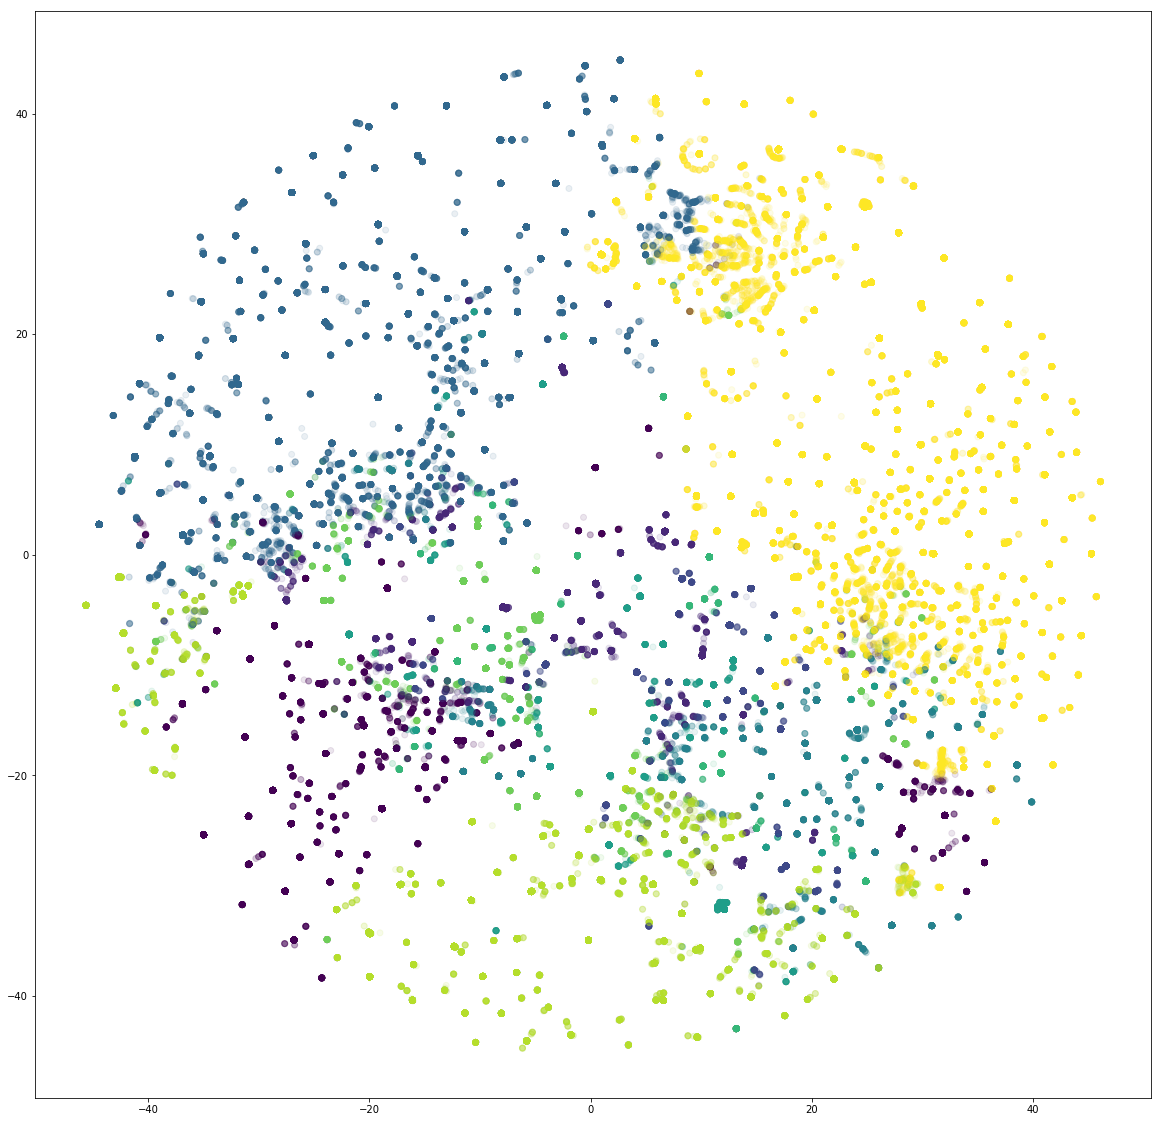

In [167]:
fig = plt.figure(figsize=(20,20))
plt.scatter(df2[0], df2[1], alpha = 0.1, c = df2['class'])

In [179]:
# heuristic measurement / quality check

indexed = df2[df2['class'] == 2].index

for i in indexed:
    print(df['Question'][i])

<a href="http://www.j-archive.com/media/2004-12-31_DJ_25.mp3">Somewhere between truth & fiction lies Marco's reality... on Halloween, you won't believe you saw it on this St.</a>
<a href="http://www.j-archive.com/media/2004-12-31_DJ_24.mp3">"500 Hats"... 500 ways to die.  On July 4th, this young boy will defy a king... & become a legend</a>
"The songs on 'Under My Skin' are...deeper than those on 'Let Go'" said this Canadian on Radio Disney's website
Once Tommy Mullaney on "L.A. Law", John Spencer now plays White House chief of staff Leo McGarry on this series
Barbra Streisand knows he played Lt. Col. Bill "Raider" Kelly on "Pensacola: Wings of Gold"
Nudge, nudge, wink, wink!  This man seen here starred on a classic British comedy show
On "Saturday Night Live", he's famous for playing Craig the Cheerleader, Janet Reno & moi
Andy's loft on East 47th Street got this nickname from its former use & Andy's mass-production techniques
In a Shaw play, Caesar finds her hiding on a Sphinx
On Sep

The Whig candidate of 1852, he held the rank of general in 3 wars
If your feet turn in, bird-brain, you're considered this
From the Latin for "projecting", it's a rich silk cloth with a raised pattern in gold or silver
1 Corinthians 15:26 -- "The last enemy that shall be destroyed is ____"
On CBS, David Letterman hosts the "Late Show", & this man hosts "The Late Late Show"
After going to the moon, Pete Conrad & Alan Bean's next trips were to this U.S. space station
In the abbreviation of the military duty in which you assist the cook
This star had close encounters in "Men In Black" & "Independence Day"
This continent's northernmost tip lies on land once called Palmer Peninsula by the U.S. & Graham Land by the British
This former movie "Batman" is a distant cousin of the poet who wrote "Trees"
Cross-country skier Bjorn Daehlie of this country won 3 golds, making him the Winter Games all-time leader
In the Slavic countries, this pungent bulb was used to detect vampires as well as to prev

Famous 1939 movie role for Jack Haley
The only "beach" in the D-Day invasion code-named for a U.S. city
In 1989 he re-recorded 8 of his classic hits for the film biography "Great Balls Of Fire!"
Peggy Cass played Agnes Gooch to this title character played by Rosalind Russell
In 1956 this title Shaw "major" was played by Glynis Johns
The first fully enclosed one of these opened in 1956 in Edina; today there's a good-sized one in Bloomington
The Amazon species of this sea cow is the only one to live exclusively in fresh water
One O' Cat is a predecessor of this game named for the places a runner had to get to & the main piece of equipment
This round hat is named for a North African city of more than half a million people
In 1971 this company brought out the 4004, the world's first commercial microprocessor
Saint Helier on Jersey is the largest town in this British island group
She laughed when told she was going to have a child, but Isaac was born a year later when she was about 91
A nat

KeyError: 132638

### LDA Model Observation:

The questions are beginning to cluster better than KMeans and DBSCAN. For example, in the '9' class, there are questions relating to talk shows and comedies starting to come out frequently. There are historical/popular figures that are frequently coming up too and that bleeds into topics pertaining to the civil war, WWII, and other conflicts. 

For topics in the '1' class, there are a lot of 'name the object/person/city' questions. This particular cluster performed really well due to the keyword "It".

Overall, the model is not perfect but I can see a pattern beginning to form and some questions clustered better than others. 


## Concluding Thoughts

LDA with T-SNE started clustering questions in a recognizable pattern. For next steps, I would consider creating a new feature called "real categories" where I sort and tag questions by their real topical categories and create a supervised learning model. This should drastically improve the performance of my model.